# SI 618 WN Project Part I

## Project Title:
> Provide a descriptive working title for your project.

**Game Sales, Popularity, and Achievements: A Comparative Analysis Across Platforms**

## Team Members
> List each team member and include their uniqname

* Yufeng Song (yfsong)
* Ziqi Wang (Venchy)
* Muyu Lin (linmuyu)

## Overview
> Give a high level description of your project

Our project explores key trends in the gaming industry by analyzing data on game sales, player achievements, and platform preferences. We aim to understand how the same game performs across different platforms, how purchasing preferences vary across countries, and how game popularity evolves over time. Additionally, we will investigate the relationship between supported languages and sales, as well as the impact of pricing on game popularity across multiple platforms. By analyzing these factors, we hope to uncover insights into player behavior, market trends, and factors influencing game success.

## Motivation
> Explain why you chose this particular topic for your project.	Include the three "real-world" questions that you generated about the data, and be sure to explain what you hope to learn by answering them.

We chose this topic because gaming is a massive industry with a highly diverse audience, and understanding player preferences and market trends can provide valuable insights for developers, publishers, and gaming communities. Our project aims to answer the following real-world questions:

1. **How do in-game achievements compare across different platforms for the same game?**

  - By analyzing achievement data, we aim to understand whether players engage with a game differently depending on the platform they use. This could reveal differences in play styles, game difficulty adjustments, or platform-specific engagement trends.

2. **How do game purchase preferences vary by country and active playtime?**

  - We seek to determine whether purchasing behaviors differ based on regional preferences and player engagement levels. Understanding this can help developers tailor their marketing strategies and optimize game pricing for different audiences.

3. **How has the popularity of different game types changed over time?**

  - By tracking shifts in game genre popularity over time, we hope to uncover trends that indicate the rise and fall of specific genres. This insight could be useful for predicting future market demands and guiding game development strategies.

By answering these questions, we hope to gain a deeper understanding of the gaming landscape, helping stakeholders make data-driven decisions about game development, pricing, and distribution strategies.

## Data Sources
> List the two (or more) sources of data that you'll be using.  Provide URLs where appropriate.	**Explain how the two (or more) datasets complement each other.**

1. https://www.kaggle.com/datasets/artyomkruglov/gaming-profiles-2025-steam-playstation-xbox

2. https://github.com/Smipe-a/gamestatshub

- This Gaming Profiles Data from Kaggle include **game** and **player** data from three different **platforms**, PlayStation, Steam, and Xbox.
- For each platform, the **player** and **game** data is complemented by **achievement** data. The relationships between players, games, and achievements are one-to-many: each player can play multiple games, and each game can have multiple achievements.
- Data from the three platforms can be combined based on **game titles** to analyze shared games across platforms.

## Data Description
> List the variables of interest, the size of the data sets, missing values, etc.

### Common Datasets Across 3 Platforms & Variables of Interest:

#### Player Metadata
- **players.csv**: platform-specific `playerid` and `country` (Xbox data lacks country column)
- **purchased_games.csv** lists players' purchased games, with:
    - `playerid`
    - `libarary`: a list of games the player bought.
- **history.csv**: when the player unlocked the achievement.
    - `playerid`
    - `achievementid`
    - `date_acquired`

#### Game Metadata
- **games.csv**: game details such as `genres`, `developers`, `publishers`, `supported_language`, and `release_date`.
- **achievements.csv** maps achievements to their respective game, with:
    - `achievementid` combines the uniqe game id on the platform and the achievement id within the game
    - `gameid`
    - `title`
    - `description`
- **prices.csv**: games' price in various currencies, with `date_acquired` indicating the date when the price was recorded.

## Data Manipulation
> Mostly code in this section.  This is where you merge your data sets, as well as create new columns (if appropriate)

#### Merged Datasets Explained - Flattened Table For Raw Analysis
- Platform-Specific Datasets:
    - Player-Info Dataset: merged on `playerid`
    - Game-Info Dataset: merged on `gameid`
- Cross-Platform Game Dataset: merged on game `title` to combine shared game data from all three platforms.

**Notes**: 
- In all the merged datasets, there are duplicated gameid/playerid after merge due to the one-to-many relationship between players, games, and achievements. 
- In the corss-platform game table, there are duplicated game titles across platforms.

In [457]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## PS

In [458]:
import os

PS_DATA_FOLDER = "data/ps"

dfs = {}

for root, dirs, files in os.walk(PS_DATA_FOLDER):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            df_name = f"{os.path.basename(root)}_{file.replace('.csv', '')}".replace('.csv', '')  # Clean name
            dfs[df_name] = pd.read_csv(file_path)

for name, df in dfs.items():
    print(f"{name} - shape: {df.shape}")

ps_purchased_games - shape: (46582, 2)
ps_history - shape: (19510083, 3)
ps_prices - shape: (62816, 7)
ps_players - shape: (356600, 3)
ps_games - shape: (23151, 8)
ps_achievements - shape: (846563, 5)


In [459]:
ps_achievements = dfs['ps_achievements']
ps_games = dfs['ps_games']
ps_history = dfs['ps_history']
ps_players = dfs['ps_players']
ps_prices = dfs['ps_prices']
ps_purchased_games = dfs['ps_purchased_games']

# check duplicates
print(ps_games.duplicated(subset=["gameid"]).sum())
print(ps_prices.duplicated(subset=["gameid"]).sum())
print(ps_achievements.duplicated(subset=["achievementid"]).sum())
print(ps_players.duplicated(subset=["playerid"]).sum())
print(ps_purchased_games.duplicated(subset=["playerid"]).sum())

0
32095
0
0
0


In [460]:
ps_prices['gameid'].value_counts()

gameid
726666    3
723091    3
727730    3
727729    3
728792    3
         ..
421567    2
421164    2
421153    2
421368    2
423969    2
Name: count, Length: 30721, dtype: int64

In [461]:
ps_prices[ps_prices['gameid'] == 726666]

,gameid,usd,eur,gbp,jpy,rub,date_acquired
20167,726666,6.99,6.99,5.79,1100.0,NaN,2025-02-22
50835,726666,6.99,6.99,5.79,1100.0,NaN,2025-02-25
52307,726666,6.99,6.99,5.79,1100.0,NaN,2025-02-24


In [462]:
# for each gameid, keep only the most recent price entry
ps_prices = ps_prices.sort_values("date_acquired").drop_duplicates(subset=["gameid"], keep="last")
print(ps_prices.duplicated(subset=["gameid"]).sum())

0


### Player focus

In [463]:
ps_player_info = ps_players.merge(ps_history, on="playerid", how="left")

In [464]:
ps_player_info = ps_player_info.merge(ps_achievements, on="achievementid", how="left")

In [465]:
ps_player_info = ps_player_info.merge(ps_purchased_games, on="playerid", how="left")

In [466]:
ps_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19861683 entries, 0 to 19861682
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   country        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   rarity         object 
 9   library        object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.5+ GB


In [467]:
ps_player_info.sample(5)

,playerid,nickname,country,achievementid,date_acquired,gameid,title,description,rarity,library
6385677,352342,KeNNedi392,Russian Federation,3462_48495,2012-09-19 18:05:07,3462.0,Insane Juggler,You dealt more than 62 damage in a midair combo.,Silver,"[697889, 420539, 601961, 622669, 647167, 49869..."
19555173,2432444,Saw__SM,Costa Rica,7691_94445,2017-08-24 07:11:59,7691.0,Exo Survivor,Successfully Complete the Exo Survival Bonus W...,Bronze,"[706747, 407954, 417808, 7779, 619583, 9459, 1..."
16525896,2266057,ADONROCK666,Brazil,417403_3782596,2021-08-26 10:08:41,417403.0,Pioneer,Reach Vinland,Bronze,"[619705, 7966, 489180, 8600, 369612, 13955, 16..."
18338068,3142882,TBD_Crazy,Portugal,145_8141,2020-11-15 00:27:04,145.0,Weaponry K.O.,Defeated first Weaponry.,Bronze,"[751920, 8993, 459211, 17630, 195206, 5520, 64..."
5961379,398579,Understockedave,United Kingdom,7780_95734,2014-11-18 13:25:21,7780.0,Quad Kill,Kill 4 enemies simultaneously with a single ex...,Bronze,"[550305, 550307, 733471, 628146, 742740, 60156..."


### Game focus
date_acquired column is dropped as it indicates the timestamp when the price info was extracted from multiple databases and do not add helpful insights to our analysis.

In [468]:
ps_game_info = ps_games.merge(ps_achievements.rename(columns={'title': 'achievement_title'}), on="gameid", how="left")

In [469]:
ps_game_info = ps_game_info.merge(ps_prices, on="gameid", how="left")

In [470]:
ps_game_info = ps_game_info.drop(columns=['date_acquired'])

In [471]:
ps_game_info.rename(columns={'platform': 'PS_platform'}, inplace=True)

In [472]:
ps_game_info.rename(columns={'description': 'achievement_description'}, inplace=True)

In [473]:
ps_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626958 entries, 0 to 626957
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameid                   626958 non-null  int64  
 1   title                    626958 non-null  object 
 2   PS_platform              626958 non-null  object 
 3   developers               626416 non-null  object 
 4   publishers               626624 non-null  object 
 5   genres                   623044 non-null  object 
 6   supported_languages      319860 non-null  object 
 7   release_date             626958 non-null  object 
 8   achievementid            626958 non-null  object 
 9   achievement_title        626954 non-null  object 
 10  achievement_description  626942 non-null  object 
 11  rarity                   626958 non-null  object 
 12  usd                      535794 non-null  float64
 13  eur                      508924 non-null  float64
 14  gbp 

PS-only cols: rarity, PS_platform

In [474]:
ps_game_info.sample(5)

,gameid,title,PS_platform,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,rarity,usd,eur,gbp,jpy,rub
346751,374,NBA Unrivaled,PS3,['A.C.R.O.N.Y.M. Games'],['KOEI TECMO GAMES CO.'],['sports'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2009-11-12,374_7417,Above The Rim,Complete an alley-oop dunk,Bronze,NaN,12.99,9.99,NaN,NaN
394865,682974,Stellar Interface,PS4,['ImaginationOverflow'],['ImaginationOverflow'],"[""Shoot 'em up""]","['French', 'Spanish', 'German', 'Portuguese', ...",2024-06-21,682974_5519871,Providence,Obtained all badges in all spacecrafts.,Bronze,17.49,20.99,16.99,2200.0,NaN
207482,357452,Word Maze by POWGI,PS Vita,['Lightwood Games'],['Lightwood Games'],['Puzzle'],NaN,2019-12-17,357452_3291851,Reign of Terrier,"Solve every puzzle in ""Dog Breeds""",Silver,NaN,NaN,NaN,NaN,NaN
582923,13756,Tales of Berseria,PS4,['BANDAI NAMCO Studios Inc.'],"['BANDAI NAMCO Entertainment', 'BANDAI NAMCO G...",['RPG'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2017-01-24,13756_144626,The Stone-Cold Killer,Proof Velvet knows 50 or more skills.\nShe'll ...,Bronze,19.99,19.99,15.99,NaN,NaN
591729,5444,Skydive: Proximity Flight,PS3,['Gaijin Entertainment'],['Gaijin Entertainment'],"['Sports', 'Skydiving']","['French', 'Spanish', 'German', 'Italian', 'Ru...",2013-10-01,5444_67751,Tricks non-stop!,Perform chain of 5 different tricks,Bronze,4.99,4.99,3.99,NaN,359.0


In [475]:
ps_game_info['achievementid'].value_counts()

achievementid
749375_6098396    1
650405_5312282    1
650406_5312373    1
650406_5312374    1
650406_5312375    1
                 ..
336965_3248824    1
336965_3248825    1
336965_3248826    1
336965_3248827    1
7593_93460        1
Name: count, Length: 626958, dtype: int64

## Steam

In [476]:
import os
import pandas as pd

STEAM_DATA_FOLDER = "data/steam"

dfs = {}

for root, dirs, files in os.walk(STEAM_DATA_FOLDER):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            df_name = f"{os.path.basename(root)}_{file.replace('.csv', '')}".replace('.csv', '')  # Clean name
            dfs[df_name] = pd.read_csv(file_path)

for name, df in dfs.items():
    print(f"{name} - shape: {df.shape}")


steam_purchased_games - shape: (102548, 2)
steam_reviews - shape: (1204534, 8)
steam_history - shape: (10693879, 3)
steam_friends - shape: (424683, 2)
steam_prices - shape: (4414273, 7)
steam_players - shape: (424683, 3)
steam_games - shape: (98248, 7)
steam_private_steamids - shape: (227963, 1)
steam_achievements - shape: (1939027, 4)


In [477]:
steam_achievements = dfs['steam_achievements']
steam_games = dfs['steam_games']
steam_history = dfs['steam_history']
steam_players = dfs['steam_players']
steam_prices = dfs['steam_prices']
steam_purchased_games = dfs['steam_purchased_games']

# check duplicates
print(steam_games.duplicated(subset=["gameid"]).sum())
print(steam_prices.duplicated(subset=["gameid"]).sum())
print(steam_achievements.duplicated(subset=["achievementid"]).sum())
print(steam_players.duplicated(subset=["playerid"]).sum())
print(steam_purchased_games.duplicated(subset=["playerid"]).sum())

0
4315808
0
0
0


In [478]:
# for each gameid, keep only the most recent price entry
steam_prices = steam_prices.sort_values("date_acquired").drop_duplicates(subset=["gameid"], keep="last")
print(steam_prices.duplicated(subset=["gameid"]).sum())

0


### Player focus

In [479]:
st_player_info = steam_players.merge(steam_history, on="playerid", how="left")

In [480]:
st_player_info = st_player_info.merge(steam_achievements, on="achievementid", how="left")

In [481]:
st_player_info = st_player_info.merge(steam_purchased_games, on="playerid", how="left")

# # Save player-focused data
# steam_player_info.to_csv('data/steam_players.csv', index=False)

In [482]:
st_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11113724 entries, 0 to 11113723
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   country        object 
 2   created        object 
 3   achievementid  object 
 4   date_acquired  object 
 5   gameid         float64
 6   title          object 
 7   description    object 
 8   library        object 
dtypes: float64(1), int64(1), object(7)
memory usage: 763.1+ MB


In [483]:
st_player_info.shape

(11113724, 9)

In [484]:
st_player_info.head(5)

,playerid,country,created,achievementid,date_acquired,gameid,title,description,library
0,76561198287452552,Brazil,2016-03-02 06:14:20,NaN,NaN,NaN,NaN,NaN,"[10, 80, 100, 240, 2990, 6880, 6910, 6920, 698..."
1,76561198040436563,Israel,2011-04-10 17:10:06,NaN,NaN,NaN,NaN,NaN,"[10, 80, 100, 300, 20, 30, 40, 50, 60, 70, 130..."
2,76561198049686270,NaN,2011-09-28 21:43:59,NaN,NaN,NaN,NaN,NaN,NaN
3,76561198155814250,Kazakhstan,2014-09-24 19:52:47,NaN,NaN,NaN,NaN,NaN,NaN
4,76561198119605821,NaN,2013-12-26 00:25:50,NaN,NaN,NaN,NaN,NaN,"[47870, 108600, 550, 271590, 331470, 381210, 2..."


### Game focus

In [485]:
st_game_info = steam_games.merge(steam_achievements.rename(columns={'title': 'achievement_title'}), on="gameid", how="left")

In [486]:
st_game_info = st_game_info.merge(steam_prices, on="gameid", how="left")

In [487]:
st_game_info = st_game_info.drop(columns=['date_acquired'])

In [488]:
st_game_info.rename(columns={'description': 'achievement_description'}, inplace=True)

In [489]:
st_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1983659 entries, 0 to 1983658
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   gameid                   int64  
 1   title                    object 
 2   developers               object 
 3   publishers               object 
 4   genres                   object 
 5   supported_languages      object 
 6   release_date             object 
 7   achievementid            object 
 8   achievement_title        object 
 9   achievement_description  object 
 10  usd                      float64
 11  eur                      float64
 12  gbp                      float64
 13  jpy                      float64
 14  rub                      float64
dtypes: float64(5), int64(1), object(9)
memory usage: 227.0+ MB


In [490]:
st_game_info.shape

(1983659, 15)

In [491]:
st_game_info['achievementid'].value_counts()

achievementid
3266470_ACHIEVEMENT_5_MINUTES    1
2578790_Liquidator               1
2578790_Space_Rebel              1
2578790_Slugger                  1
2578790_Sergeant                 1
                                ..
1098080_ACHIEVEMENT_9            1
1098080_ACHIEVEMENT_8            1
1098080_ACHIEVEMENT_7            1
1098080_ACHIEVEMENT_6            1
1499240_ROMANROCKS               1
Name: count, Length: 1935882, dtype: int64

## XBOX

In [492]:
import os
import pandas as pd

XBOX_DATA_FOLDER = "data/xbox"

dfs = {}

for root, dirs, files in os.walk(XBOX_DATA_FOLDER):
    for file in files:
        if file.endswith(".csv"):
            file_path = os.path.join(root, file)
            df_name = f"{os.path.basename(root)}_{file.replace('.csv', '')}".replace('.csv', '')
            dfs[df_name] = pd.read_csv(file_path)

for name, df in dfs.items():
    print(f"{name} - shape: {df.shape}")


xbox_purchased_games - shape: (46466, 2)
xbox_history - shape: (15275900, 3)
xbox_prices - shape: (22638, 7)
xbox_players - shape: (274450, 2)
xbox_games - shape: (10489, 7)
xbox_achievements - shape: (351111, 5)


In [493]:
xbox_achievements = dfs['xbox_achievements']
xbox_games = dfs['xbox_games']
xbox_history = dfs['xbox_history']
xbox_players = dfs['xbox_players']
xbox_prices = dfs['xbox_prices']
xbox_purchased_games = dfs['xbox_purchased_games']

# check duplicates
print(xbox_games.duplicated(subset=["gameid"]).sum())
print(xbox_prices.duplicated(subset=["gameid"]).sum())
print(xbox_achievements.duplicated(subset=["achievementid"]).sum())
print(xbox_players.duplicated(subset=["playerid"]).sum())
print(xbox_purchased_games.duplicated(subset=["playerid"]).sum())

0
11319
0
0
0


In [494]:
# for each gameid, keep only the most recent price entry
xbox_prices = xbox_prices.sort_values("date_acquired").drop_duplicates(subset=["gameid"], keep="last")
print(xbox_prices.duplicated(subset=["gameid"]).sum())

0


### Player focus

In [495]:
xb_player_info = xbox_players.merge(xbox_history, on="playerid", how="left")

In [496]:
xb_player_info = xb_player_info.merge(xbox_achievements, on="achievementid", how="left")

In [497]:
xb_player_info = xb_player_info.merge(xbox_purchased_games, on="playerid", how="left")

In [498]:
xb_player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15545366 entries, 0 to 15545365
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   playerid       int64  
 1   nickname       object 
 2   achievementid  object 
 3   date_acquired  object 
 4   gameid         float64
 5   title          object 
 6   description    object 
 7   points         float64
 8   library        object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ GB


In [499]:
xb_player_info.shape

(15545366, 9)

### Game focus

In [500]:
xb_game_info = xbox_games.merge(xbox_achievements.rename(columns={'title': 'achievement_title'}), on="gameid", how="left")

In [501]:
xb_game_info = xb_game_info.merge(xbox_prices, on="gameid", how="left")

In [502]:
xb_game_info = xb_game_info.drop(columns=['date_acquired', 'points'])

In [503]:
xb_game_info.rename(columns={'description': 'achievement_description'}, inplace=True)

In [504]:
xb_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323038 entries, 0 to 323037
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameid                   323038 non-null  int64  
 1   title                    323038 non-null  object 
 2   developers               304402 non-null  object 
 3   publishers               305059 non-null  object 
 4   genres                   304168 non-null  object 
 5   supported_languages      132805 non-null  object 
 6   release_date             323038 non-null  object 
 7   achievementid            323038 non-null  object 
 8   achievement_title        323037 non-null  object 
 9   achievement_description  322984 non-null  object 
 10  usd                      237247 non-null  float64
 11  eur                      226837 non-null  float64
 12  gbp                      234618 non-null  float64
 13  jpy                      0 non-null       float64
 14  rub 

## Game Info Across Platforms

In [505]:
len(ps_game_info['gameid'].unique())

23151

In [506]:
len(st_game_info['gameid'].unique())

98248

In [507]:
len(xb_game_info['gameid'].unique())

10489

In [508]:
ps_titles = set(ps_game_info['title'].str.lower().str.strip())
st_titles = set(st_game_info['title'].str.lower().str.strip())
xb_titles = set(xb_game_info['title'].str.lower().str.strip())

shared_ps_st = ps_titles.intersection(st_titles)
shared_ps_xb = ps_titles.intersection(xb_titles)
shared_st_xb = st_titles.intersection(xb_titles)
shared_all = ps_titles.intersection(st_titles, xb_titles)

print(f"Shared titles between PS & ST: {len(shared_ps_st)}")
print(f"Shared titles between PS & XB: {len(shared_ps_xb)}")
print(f"Shared titles between ST & XB: {len(shared_st_xb)}")
print(f"Shared across all three: {len(shared_all)}")


Shared titles between PS & ST: 5571
Shared titles between PS & XB: 5360
Shared titles between ST & XB: 5540
Shared across all three: 3815


In [509]:
def clean_game_info(df, platform):
    df = df.copy()
    
    # drop platform-specific columns (ps_game_info's 'rarity' and 'PS_platform')
    drop_cols = ['date_acquired', 'rarity', 'PS_platform']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

    # add platform column
    df['platform'] = platform
    
    return df

In [510]:
ps_game_info_clean = clean_game_info(ps_game_info, 'ps')

In [511]:
ps_game_info_clean.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'usd', 'eur', 'gbp',
       'jpy', 'rub', 'platform'],
      dtype='object')

In [512]:
st_game_info_clean = clean_game_info(st_game_info, 'st')

In [513]:
st_game_info_clean.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'usd', 'eur', 'gbp',
       'jpy', 'rub', 'platform'],
      dtype='object')

In [514]:
xb_game_info_clean = clean_game_info(xb_game_info, 'xb')

In [515]:
xb_game_info_clean.columns

Index(['gameid', 'title', 'developers', 'publishers', 'genres',
       'supported_languages', 'release_date', 'achievementid',
       'achievement_title', 'achievement_description', 'usd', 'eur', 'gbp',
       'jpy', 'rub', 'platform'],
      dtype='object')

In [516]:
shared_games = set(ps_game_info_clean['title']) & set(st_game_info_clean['title']) & set(xb_game_info_clean['title'])

ps_game_info_clean = ps_game_info_clean[ps_game_info_clean['title'].isin(shared_games)]
st_game_info_clean = st_game_info_clean[st_game_info_clean['title'].isin(shared_games)]
xb_game_info_clean = xb_game_info_clean[xb_game_info_clean['title'].isin(shared_games)]

merged_game_info = pd.concat([ps_game_info_clean, st_game_info_clean, xb_game_info_clean], ignore_index=True)

print(f"Merged dataset shape: {merged_game_info.shape}")

Merged dataset shape: (431985, 16)


In [517]:
merged_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431985 entries, 0 to 431984
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameid                   431985 non-null  int64  
 1   title                    431985 non-null  object 
 2   developers               430744 non-null  object 
 3   publishers               430459 non-null  object 
 4   genres                   430507 non-null  object 
 5   supported_languages      274284 non-null  object 
 6   release_date             431985 non-null  object 
 7   achievementid            431807 non-null  object 
 8   achievement_title        431801 non-null  object 
 9   achievement_description  414137 non-null  object 
 10  usd                      398232 non-null  float64
 11  eur                      386835 non-null  float64
 12  gbp                      396497 non-null  float64
 13  jpy                      186153 non-null  float64
 14  rub 

In [518]:
merged_game_info['achievementid'].value_counts()

achievementid
749591_6100112             1
384010_PIECE_OF_CAKE       1
384180_ACH_SHOP_A_HOLIC    1
384180_ACH_BLACKJACK       1
384180_ACH_BILLIONAIRE     1
                          ..
603576_4978957             1
603576_4978956             1
603576_4978955             1
603576_4978954             1
711118_5703719             1
Name: count, Length: 431807, dtype: int64

In [519]:
merged_game_info['platform'].value_counts()

platform
ps    205901
st    114850
xb    111234
Name: count, dtype: int64

## Long and Tidy Form
A tidy dataset follows the principles:
1. Each column is a single variable.
2. Each row is a single observation.
3. Each cell contains a single value.

#### Issues with the current merged_game_info:
- **We decide to leave it unchanged as our analysis will base on it**: The platform column is categorical, meaning the same game can appear multiple times (once per platform). This makes it long format.
- Price columns (usd, eur, etc.) are separate instead of melted into a single column, which makes the dataset wide instead of long, which is not tidy.

In [520]:
# convert price columns into a long format
tidy_game_info = merged_game_info.melt(
    id_vars=[
        "gameid", "title", "developers", "publishers", "genres",
        "supported_languages", "release_date", "achievementid",
        "achievement_title", "achievement_description", "platform"
    ],
    value_vars=["usd", "eur", "gbp", "jpy", "rub"],
    var_name="currency",
    value_name="price"
)

In [521]:
tidy_game_info.shape

(2159925, 13)

In [522]:
tidy_game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159925 entries, 0 to 2159924
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   gameid                   int64  
 1   title                    object 
 2   developers               object 
 3   publishers               object 
 4   genres                   object 
 5   supported_languages      object 
 6   release_date             object 
 7   achievementid            object 
 8   achievement_title        object 
 9   achievement_description  object 
 10  platform                 object 
 11  currency                 object 
 12  price                    float64
dtypes: float64(1), int64(1), object(11)
memory usage: 214.2+ MB


In [523]:
tidy_game_info.sample(5)

,gameid,title,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,platform,currency,price
254263,1018160,MXGP 2019 - The Official Motocross Videogame,['Milestone S.r.l.'],['Milestone S.r.l.'],"['Racing', 'Simulation', 'Sports']","['English', 'French', 'Italian', 'German', 'Sp...",2019-08-27,1018160_ML_ACHIEVEMENT_47,The time machine,Use the Rewind for the first time in any game ...,st,usd,24.99
1595745,314830,Blackguards 2,['Daedalic Entertainment'],['Daedalic Entertainment'],"['Adventure', 'Indie', 'RPG', 'Strategy']","['English', 'French', 'Italian', 'German', 'Sp...",2015-01-20,314830_achievement_21,Kyria for a Day,Cassia is beloved by the people,st,jpy,1180.00
1382135,163189,Immortal: Unchained,['Toadman Interactive'],['Toadman Interactive'],['RPG'],"['Japanese', 'French', 'Spanish', 'German', 'I...",2018-09-07,163189_2797266,Hello World,Connect with the Monolith,ps,jpy,NaN
1144638,530320,Wandersong,"['Wishes Ultd.', 'Greg Lobanov', 'A Shell in t...",['Greg Lobanov'],"['Adventure', 'Indie']",['English'],2018-09-27,530320_OVERSEER6,Heartbreaker,NaN,st,gbp,14.99
468550,530702,Maggie the Magnet,"['Khud0', 'eastasiasoft']",['eastasiasoft'],['Puzzle'],['Russian'],2022-09-16,530702_4526846,Invisibility,Disappear.,ps,eur,4.99


In [524]:
tidy_game_info['achievementid'].value_counts()

achievementid
749591_6100112             5
384010_PIECE_OF_CAKE       5
384180_ACH_SHOP_A_HOLIC    5
384180_ACH_BLACKJACK       5
384180_ACH_BILLIONAIRE     5
                          ..
603576_4978957             5
603576_4978956             5
603576_4978955             5
603576_4978954             5
711118_5703719             5
Name: count, Length: 431807, dtype: int64

## Preprocessing

### 1. Check for missing values

In [525]:
# count missing values per column
null_counts = tidy_game_info.isnull().sum().reset_index()
null_counts.columns = ["col", "num_missing"]
null_counts["missing_pcnt"] = round((null_counts["num_missing"] / len(merged_game_info)) * 100, 2)

null_counts

,col,num_missing,missing_pcnt
0,gameid,0,0.00
1,title,0,0.00
2,developers,6205,1.44
3,publishers,7630,1.77
4,genres,7390,1.71
5,supported_languages,788505,182.53
6,release_date,0,0.00
7,achievementid,890,0.21
8,achievement_title,920,0.21
9,achievement_description,89240,20.66


#### Here’s how we decide to handle missing values effectively [Used GPT-4o for tailoring to table format]:

**Columns with Minor Missing Data (< 5%)**
| Column | Missing % | Suggested Action |
|---------|----------|-----------------|
| **developers** | 0.27% | Fill with "unknown" to maintain consistency. |
| **publishers** | 1.38% | Fill with "unknown" for completeness. |
| **genres** | 0.43% | Fill with "unknown", since games without a genre classification are rare. |
| **achievementid** | 0.69% | Likely an error or missing achievements, can be kept as NaN. |
| **achievement_title** | 0.69% | Likely corresponds to missing achievementid, can be kept as NaN. |

- **Action: Fill developers, publishers, and genres with "unknown", and leave missing achievements as NaN.**

---

**Columns with Moderate Missing Data (5% - 30%)**
| Column | Missing % | Suggested Action |
|---------|----------|-----------------|
| **supported_languages** | 27.35% | Keep as NaN, since language availability is an actual missing feature. |

- **Action: Keep supported_languages as NaN, since not all games support multiple languages. We don't want to introduce incorrect data.**

---

**Columns with High Missing Data (> 50%)**
| Column | Missing % | Suggested Action |
|---------|----------|-----------------|
| **achievement_description** | 69.11% | Fill missing values with "unknown". |
| **price** | 71.58% | Keep as NaN—missing prices could indicate unavailable data, regional limitations, or discontinued games. |

**Action:**
- **Fill achievement_description with "No description available"** to avoid empty fields.
- **Keep price as NaN**, since forcing imputation could lead to inaccurate pricing.

In [526]:
# fill missing values for categorical text columns
tidy_game_info["developers"].fillna("unknown", inplace=True)
tidy_game_info["publishers"].fillna("unknown", inplace=True)
tidy_game_info["genres"].fillna("unknown", inplace=True)
tidy_game_info["achievement_description"].fillna("unknown", inplace=True)

/var/folders/sd/5vy204s55_ggyjh65z1tlxg00000gn/T/ipykernel_43239/1875302043.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tidy_game_info["developers"].fillna("unknown", inplace=True)
/var/folders/sd/5vy204s55_ggyjh65z1tlxg00000gn/T/ipykernel_43239/1875302043.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

## 2. Multi-valued cols

In [527]:
tidy_game_info.sample(5)

,gameid,title,developers,publishers,genres,supported_languages,release_date,achievementid,achievement_title,achievement_description,platform,currency,price
2114175,750641,Nine Sols,['Red Candle Games'],['Red Candle Games'],"['Platformer', 'Metroidvania']",NaN,2024-11-26,750641_6111986,"I'm Coming for You, Old Friend",Defeat Yingzhao.,xb,rub,2664.00
1780954,453048,Catlateral Damage: Remeowstered,['Manekoware'],['Manekoware'],['Action'],NaN,2021-09-15,453048_4073695,Photo Collector,Collect 100 photos,ps,rub,929.00
1628908,549724,Starsand,"['Tunnel Vision Studio', 'Fantastico Studio']",['Toplitz Productions'],['Survival'],NaN,2022-11-17,549724_4595583,"Been there, done death",Experience death for the first time,xb,jpy,NaN
64929,410964,One Finger Death Punch 2,['Silver Dollar Games'],['Silver Dollar Games'],['Indie'],NaN,2020-09-30,410964_3745419,I'm the Real Boss,Kill 250 bosses,ps,usd,8.99
97496,17564,Embers of Mirrim,['Creative Bytes Studios'],['Creative Bytes Studios'],['Indie'],"['French', 'Spanish', 'German', 'Italian']",2017-05-23,17564_172886,Rim's Power,Gain the power of Dark Embers,ps,usd,14.99


#### Handling Multi-Valued Columns in Our Dataset [Used GPT-4o for tailoring grammar]

Our dataset contains multi-valued columns such as `developers`, `publishers`, `genres`, and `supported_languages`, which are stored as **list-like strings**. Instead of immediately expanding them into multiple rows (long format) or separate columns (one-hot encoding), we are **keeping them in their original format** for the following reasons:

1. **Data Integrity & Storage Efficiency**  
   - Expanding these fields would significantly increase row count, making storage and initial processing heavier.
   - Keeping them as lists allows us to preserve all information within a single row per game.

2. **Flexibility for Future Analysis**  
   - At later stages, we may **apply one-hot encoding** to `genres` and `supported_languages` for categorical analysis.  
   - Alternatively, we can derive **summary features** such as:
     - **Number of genres per game**
     - **Number of supported languages**
     - **Unique count of developers/publishers**
   - These derived features will allow for a more structured comparison across games.

By postponing transformation, we maintain efficiency while keeping the option open for structured feature extraction when needed.


In [528]:
# tidy_game_info_noids = tidy_game_info.drop(columns=['gameid', 'achievementid'], inplace=True)

## More notes on further merging

Our current **tidy dataset** focuses solely on game-related information. To enrich the analysis, we plan additional merges with player data to uncover insights about game popularity, completion rates, and player demographics.

### Planned Merges & Insights
1. **Game Popularity Analysis**  
   - Merge with `purchased_games.csv` (for each platform) to **count the number of players who own each game**.
   - This helps identify **best-selling games** and platform-specific purchase trends.

2. **Game Completion Rates**  
   - Merge with `history.csv` to **track when players earn end-game achievements**.
   - Calculate the **average time to completion** and **percentage of players finishing a game**.
   - Investigate if certain **genres have higher completion rates** (e.g., RPGs vs. casual games).
  
3. **Pricing & Sales Relationship:**  
   - Merge `prices.csv` to analyze how **price fluctuations impact purchases**.
  
4. **Cross-Platform Player Behavior:**  
   - Identify players who own **the same game across multiple platforms** to study cross-platform engagement.
   - Merge with `players.csv` and **cluster by country** to analyze **regional gaming preferences**.


## Data Visualization
> Be sure to include interpretations of your visualizations -- what patterns or anomalies do you see?


### Price Distribution of Shared Games Across Platforms

Interpretation: 
- The majority of shared games are priced between 5 to 25 USD.
- Games on Steam are generally priced the lowest, while Xbox games tend to be priced higher compared to the other two platforms.

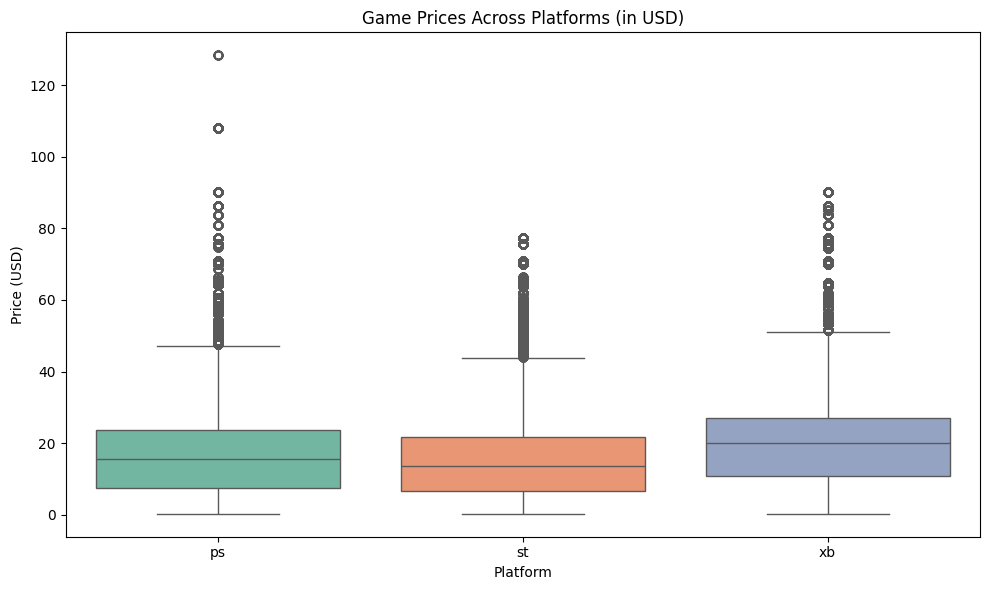

In [529]:
### Boxplot visualizing the distribution of game prices (in USD) across platforms

# Convert prices to USD
exchange_rates = {
    'eur': 1.08, 
    'gbp': 1.29, 
    'jpy': 0.0067,
    'rub': 0.012, 
    'usd': 1.0
}

tidy_game_info['price_usd'] = tidy_game_info.apply(
    lambda row: row['price'] * exchange_rates.get(row['currency'].lower(), 1.0), axis=1
)

# Visualize price distribution across platforms
plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='price_usd', hue='platform', data=tidy_game_info, palette='Set2', legend=False)

plt.title("Game Prices Across Platforms (in USD)")
plt.xlabel("Platform")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

### Number of Achievements Distribution of Shared Games Across Platforms

Interpretation:
- The number of achievements per game typically stays below 50, with a few outliers over 1000.
- PlayStation games generally feature more achievements than games on other platforms.

count    10398.000000
mean        41.527890
std         61.519762
min          0.000000
25%         19.000000
50%         31.000000
75%         50.000000
max       4820.000000
Name: achievements_per_game, dtype: float64


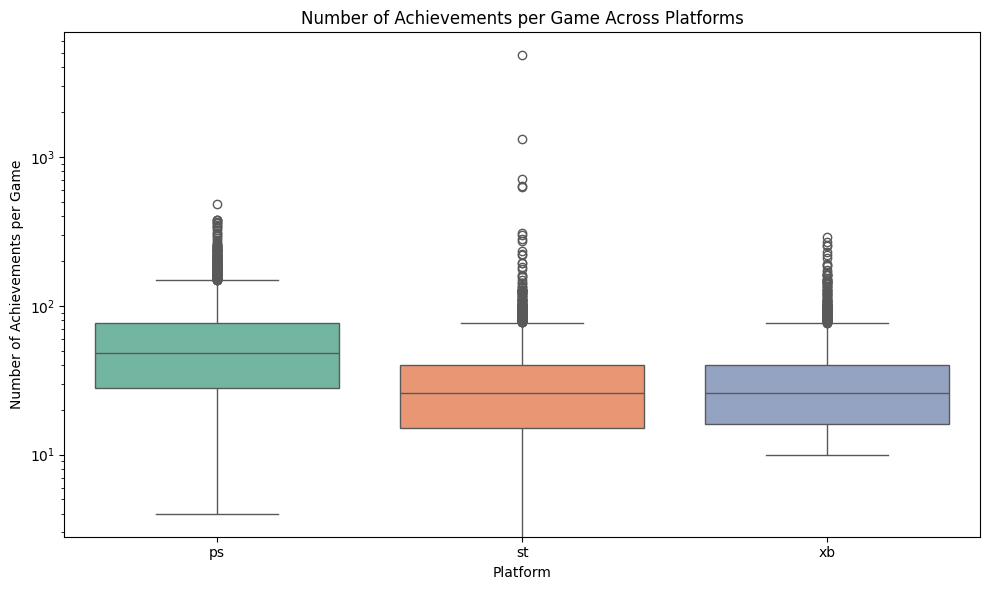

In [530]:
### Boxplot visualizing the distribution of the number of achievements per game across platform

achievements_per_game = tidy_game_info.groupby(["title", "platform"])["achievementid"].nunique().reset_index()
achievements_per_game.rename(columns={"achievementid": "achievements_per_game"}, inplace=True)

print(achievements_per_game['achievements_per_game'].describe())

plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='achievements_per_game', hue='platform', data=achievements_per_game, palette='Set2', legend=False)

plt.title("Number of Achievements per Game Across Platforms")
plt.xlabel("Platform")
plt.ylabel("Number of Achievements per Game")
plt.yscale('log')
plt.tight_layout()
plt.show()

### Distribution of Top 10 Popular Genres of Shared Games Across Platforms

Interpretation: 
- The Top 10 popular genres of the shared games across platforms are Indie, Adventure, Action, RPG, Simulation, Strategy, Platformer, Casual, Turn Based, and Puzzle.
- Steam games cover the majority of the top 10 popular genres, with the highest percentages in genres like Indie, Adventure, Action, Simulation, and Casual.

platform          ps         st        xb
genres                                   
Indie       7.111988  21.286433  5.377374
Adventure   7.651840  15.989195  9.944078
Action      3.637378  21.155339  7.477222
RPG         7.748229   7.982374  7.204869
Simulation  3.650442   7.894061  4.251958
Strategy    3.224986   6.535450  3.247911
Platformer  7.419870   0.000000  4.897708
Casual      0.308587   9.025932  0.375719
Turn Based  4.603744   0.000000  4.152657
Puzzle      4.182173   0.000000  3.135834


<Figure size 1200x800 with 0 Axes>

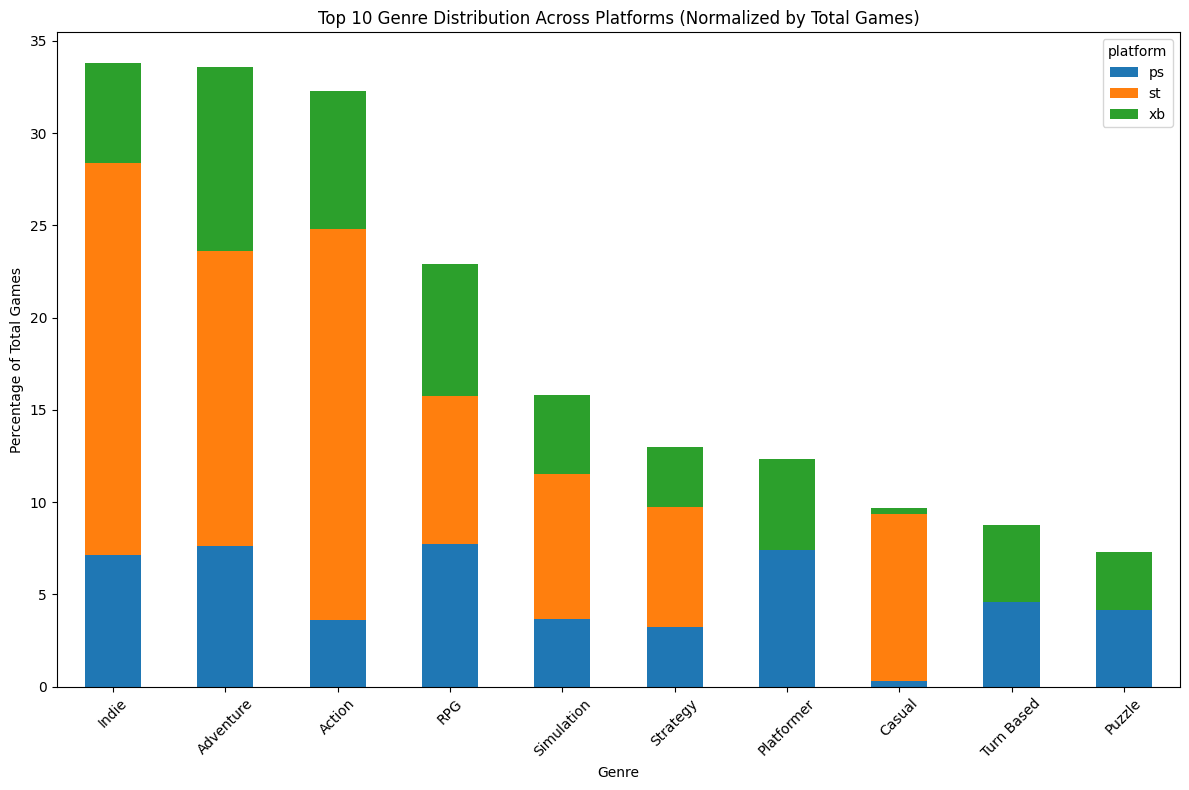

In [535]:
### Stacked barplot visualizing the distribution of the top 10 genres across different platforms

# Clean and explode genres into separate rows
tidy_game_info['genres'] = tidy_game_info['genres'].apply(lambda x: x.strip("[]").replace("'", '').split(', ') if isinstance(x, str) else x)
tidy_game_info = tidy_game_info.explode('genres')  

# Replace 'Role Playing' genre with 'RPG' genre
tidy_game_info['genres'] = tidy_game_info['genres'].replace({'Role Playing': 'RPG'})

# Normalize genre counts by the total number of games on each platform
total_games_per_platform = tidy_game_info['platform'].value_counts()
genre_counts_per_platform = tidy_game_info.groupby(['platform', 'genres']).size().reset_index(name='count')
genre_counts_per_platform['percentage'] = genre_counts_per_platform.apply(
    lambda row: row['count'] / total_games_per_platform[row['platform']] * 100, axis=1
)

# Select top 10 genres
top_10_genres = genre_counts_per_platform.groupby('genres')['percentage'].sum().sort_values(ascending=False).head(10).index
top_10_genre_data = genre_counts_per_platform[genre_counts_per_platform['genres'].isin(top_10_genres)]

tidy_game_info['genres'] = tidy_game_info['genres'].replace({'Role Playing': 'RPG'})
# Pivot the data to prepare for stacking by platform with genres on the x-axis
top_10_genre_data_pivot = top_10_genre_data.pivot_table(
    index='genres', columns='platform', values='percentage', aggfunc='sum', fill_value=0
)
top_10_genre_data_pivot = top_10_genre_data_pivot.loc[top_10_genres]
print(top_10_genre_data_pivot)

# Create a stacked bar plot
plt.figure(figsize=(12, 8))
top_10_genre_data_pivot.plot(kind='bar', stacked=True, figsize=(12, 8))

plt.title('Top 10 Genre Distribution Across Platforms (Normalized by Total Games)')
plt.xlabel('Genre')
plt.ylabel('Percentage of Total Games')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()